### Project Matrix completion
#### Nuclear Norm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from argparse import ArgumentParser
#from matrix_completion import *
from PIL import Image

from cvxpy import *
#from skimage.measure import compare_ssim as ssim

In [2]:
from skimage.metrics import structural_similarity as ssim
import cv2

In [3]:
def plot_image(A, title=None):
    #plt.imshow(A.T)
    plt.imshow(A)
    plt.title(title, fontsize=15)
    #plt.show()

In [4]:
def rgb2gray(image):
    r, g, b = image[:,:,0], image[:,:,1], image[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

In [5]:
def pepper_salt_noise(p,image):
    m, n = image.shape
    frac = 1- p
    sample = np.random.binomial(1, frac, size=m*n)
    mask = np.reshape(sample, (m, n))
    image_noise = image * mask
    return mask, image_noise

In [6]:
def calc_unobserved_rmse(A, A_hat, mask_):
    """
    Calculate RMSE on all unobserved entries in mask, for true matrix UVᵀ.

    Parameters
    ----------
    A : m x n array true matrix
    A_hat : m x n array estimated matrix
    mask : m x n x c array 

    Returns:
    --------
    rmse : float, root mean squared error over all unobserved entries
    """
    pred = np.multiply(A_hat, (1 - mask))
    truth = np.multiply(A, (1 - mask))
    
    return (np.linalg.norm(pred - truth, "fro") ** 2 / np.sum(1 - mask)) ** 0.5


In [7]:
def nuclear_norm_solve(A, mask, mu=1.0):
    """
    Solve using a nuclear norm approach, using CVXPY.
    [ Candes and Recht, 2009 ]

    Parameters:
    -----------
    A : m x n array matrix we want to complete
    mask : m x n array matrix with entries zero (if missing) or one (if present)
    mu : float hyperparameter controlling tradeoff between nuclear norm and square loss

    Returns:
    --------
    X: m x n array, completed matrix
    """
    X = Variable(shape=A.shape)
    objective = Minimize(mu * norm(X, "nuc") +
                         sum_squares(multiply(mask, X - A)))
    problem = Problem(objective, [])
    problem.solve(solver=SCS)
    return X.value

#### Load image

In [8]:
image = 'persian_girl.jpg'
img = np.array(Image.open(image, mode='r'), dtype=np.uint8)/255

In [9]:
img = rgb2gray(img)

In [10]:
m, n = img.shape

noise = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
#mask_prob = 0.9

In [11]:
def plot_proc(img1, img2, title):
    # Plot original image and distorted
    plt.figure(figsize=[20, 10])
    plt.subplot(121)
    plot_image(img1, 'True Image')

    plt.subplot(122)
    plot_image(img2, title)

<Figure size 1440x720 with 0 Axes>

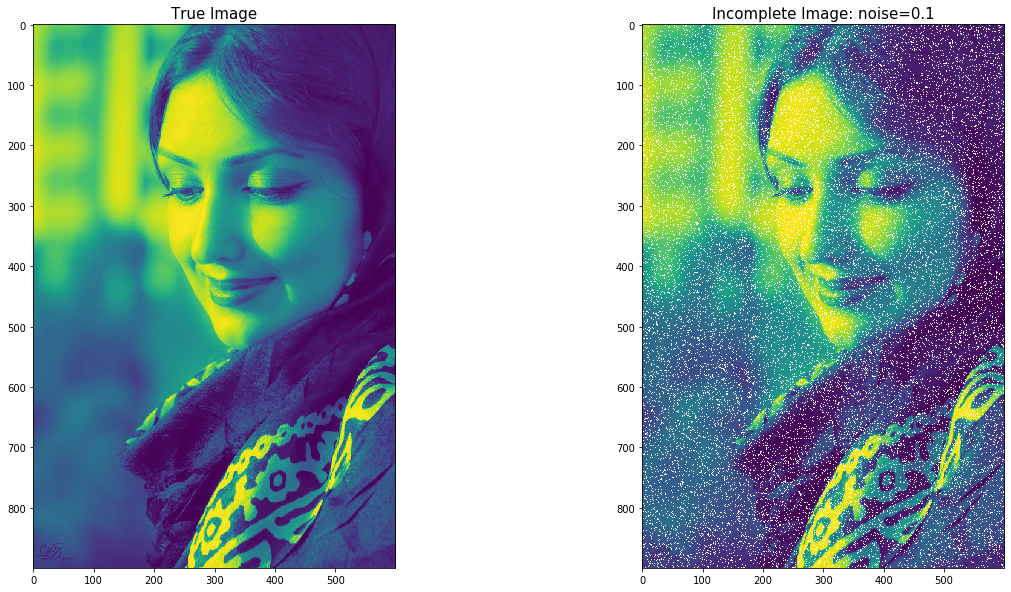

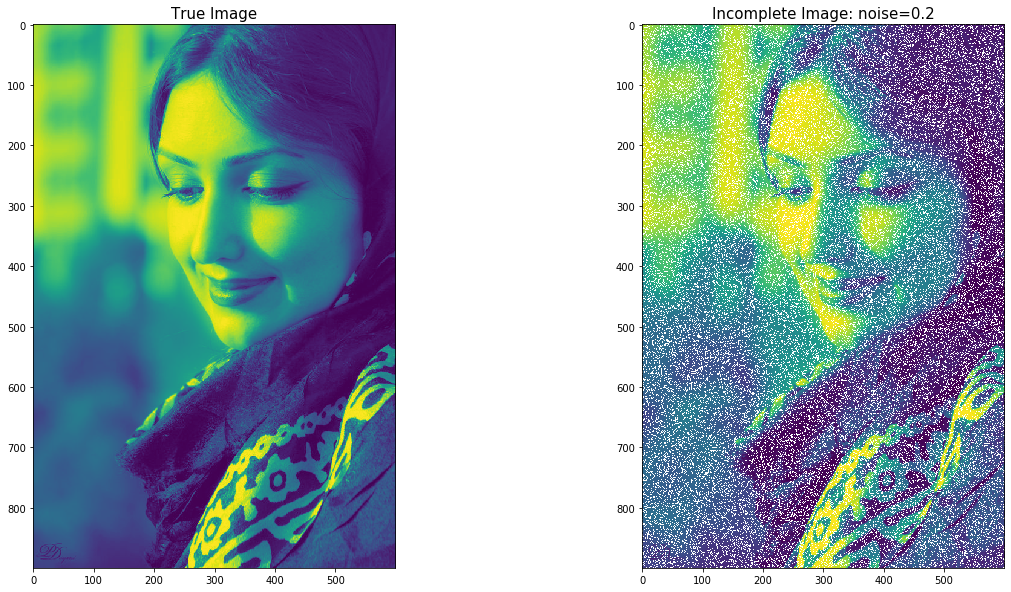

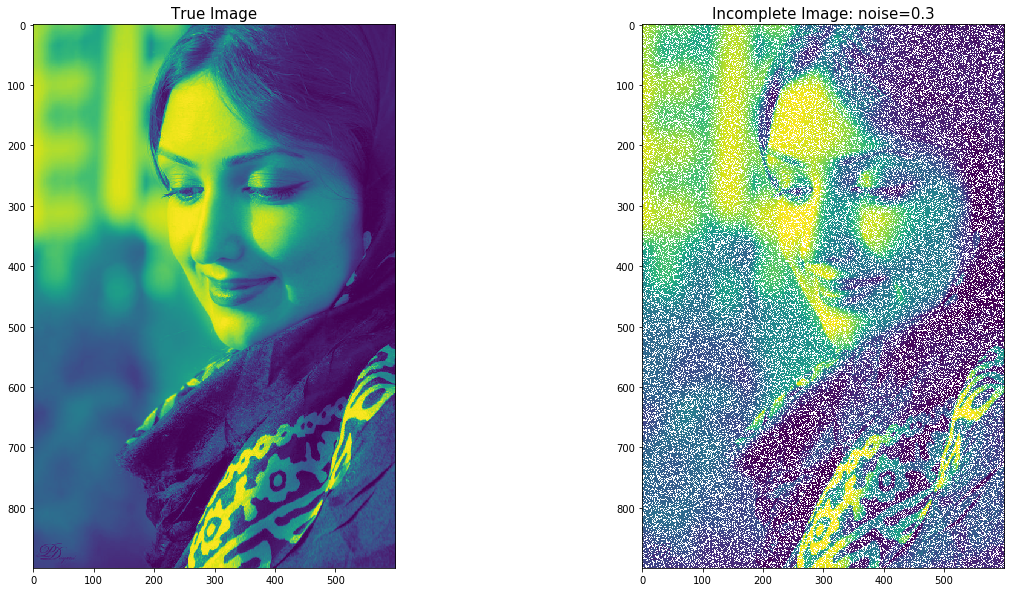

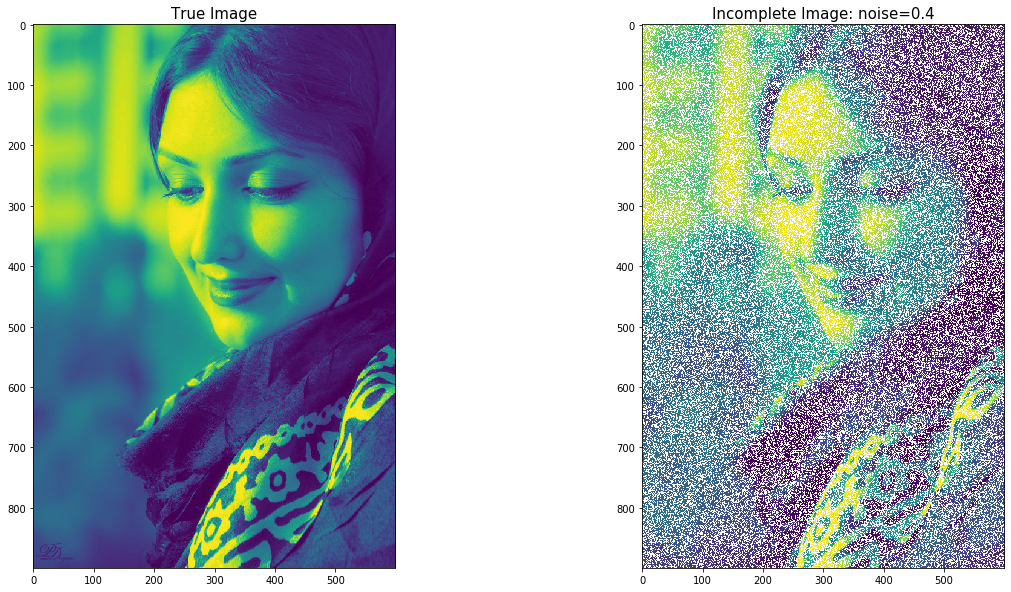

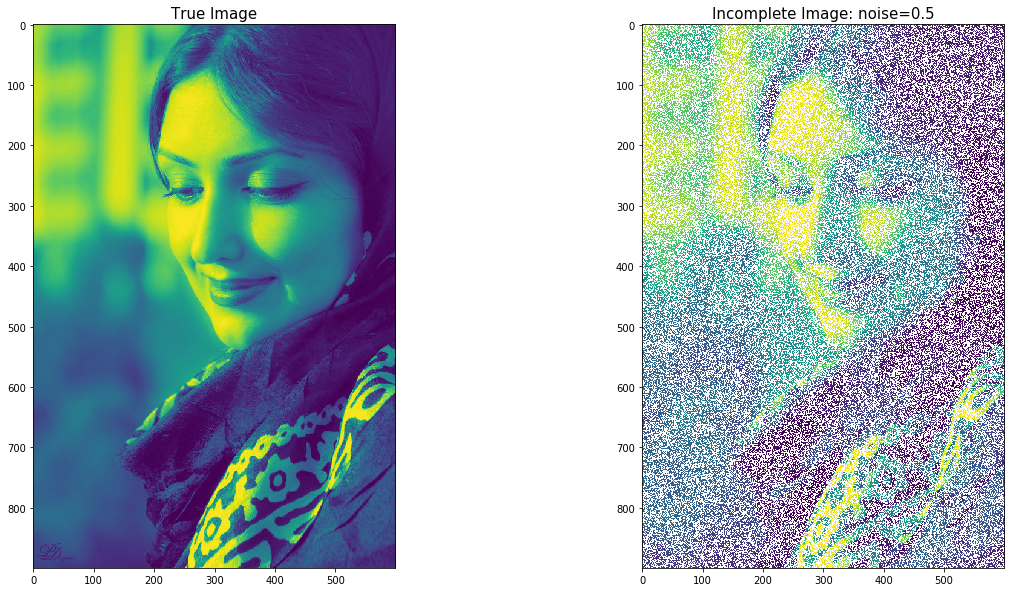

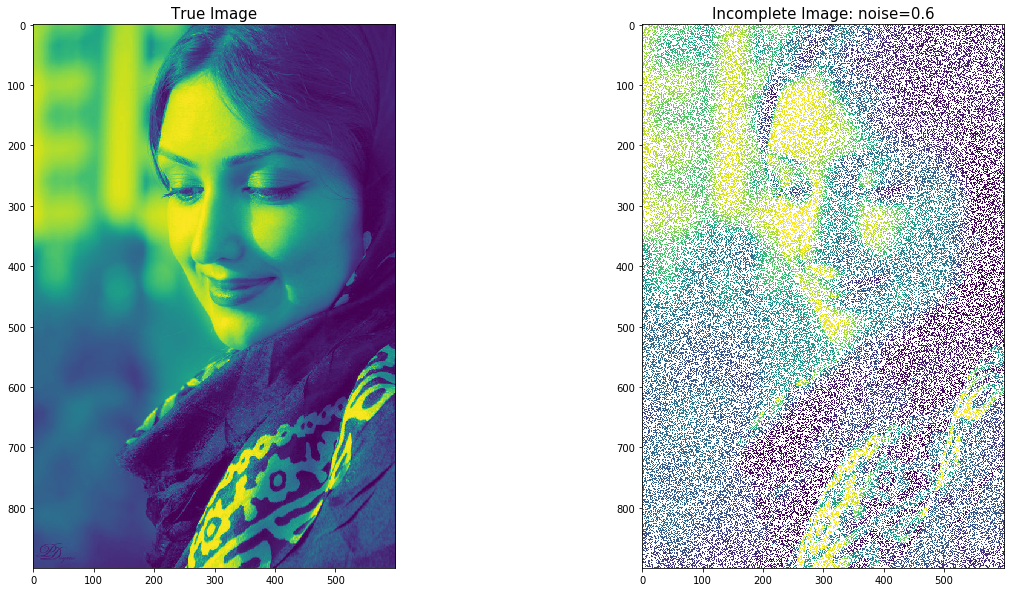

In [12]:
plt.figure(figsize=(20, 10))
i = 0
for k, n in enumerate(noise):
    mask, img_noise = pepper_salt_noise(n, img)
    img_damaged = np.where(mask == 0, np.nan, img_noise)
    plot_proc(img, img_damaged, 'Incomplete Image: noise='+str(n))

** NUCN
RMSE: 0.027810694406582376
SSIM 0.9807954048791688
** NUCN
RMSE: 0.03104545370985251
SSIM 0.9726827814450131
** NUCN
RMSE: 0.03389692687486206
SSIM 0.9619041699533064
** NUCN
RMSE: 0.038241198689912735
SSIM 0.9466959092145227
** NUCN
RMSE: 0.04324327928082007
SSIM 0.9265063839711689
** NUCN
RMSE: 0.05036132885779678
SSIM 0.898537701003488


<Figure size 1440x720 with 0 Axes>

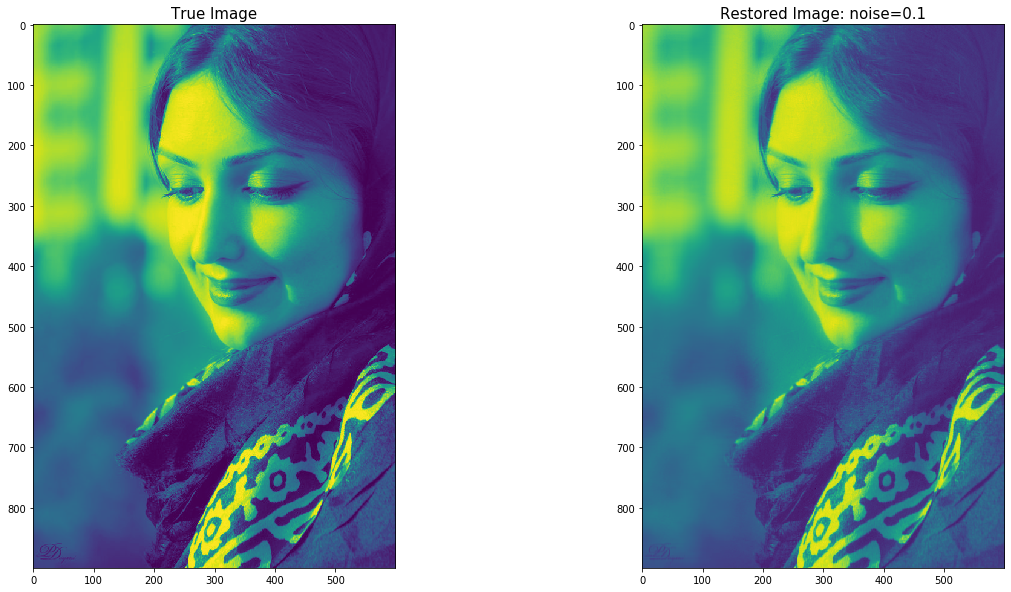

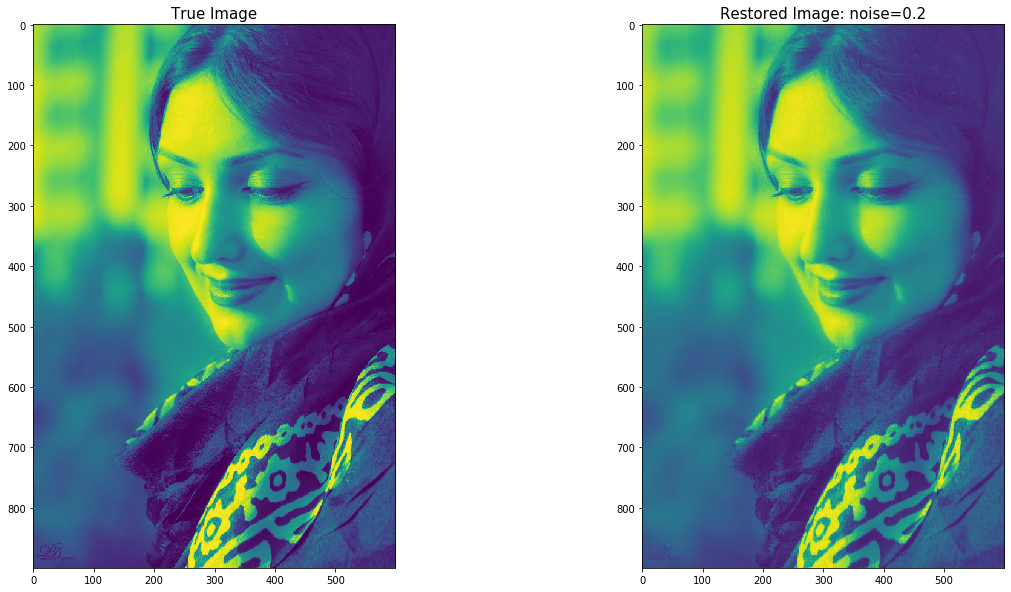

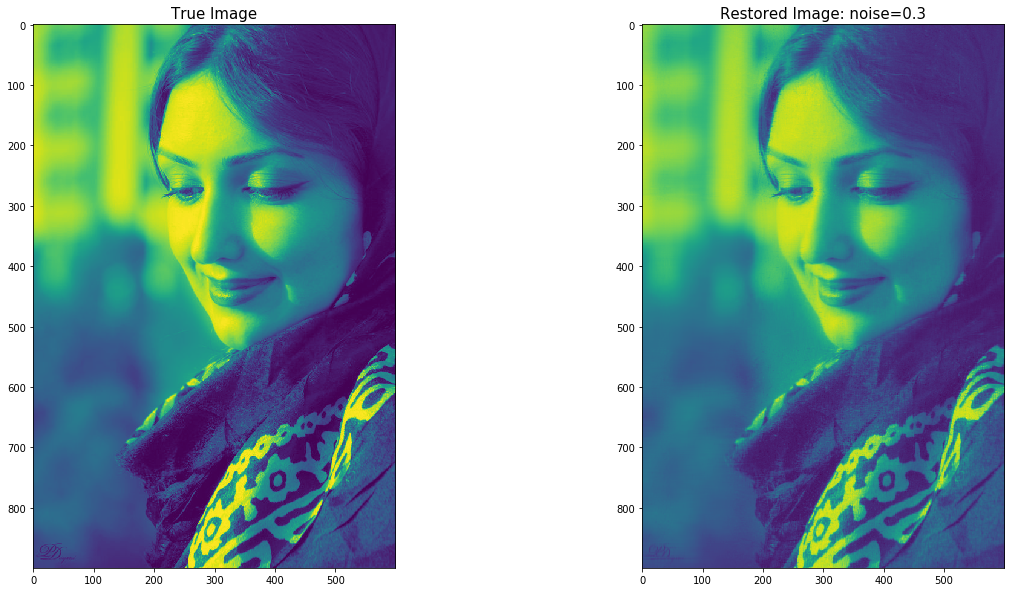

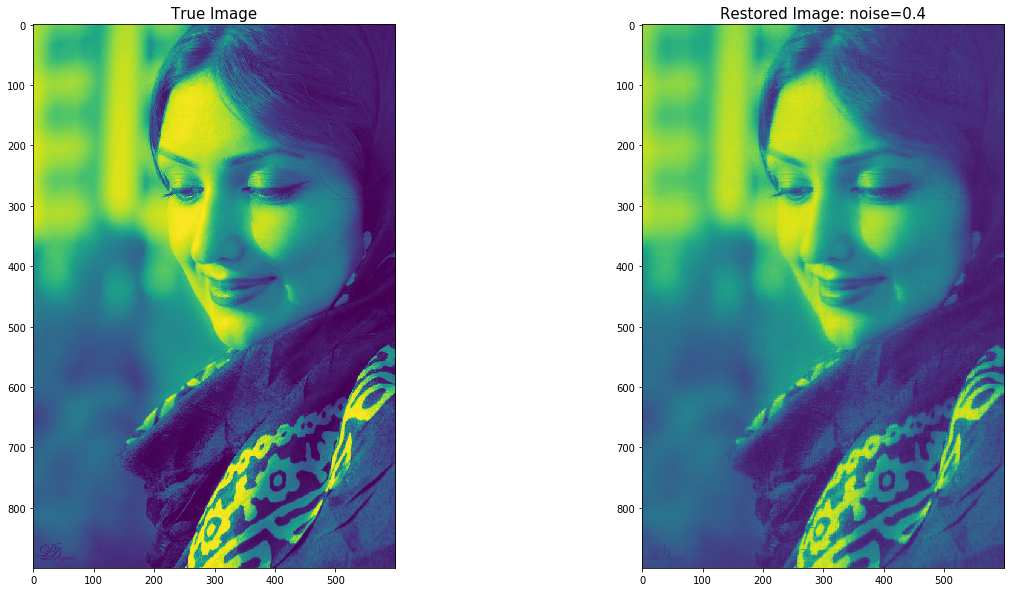

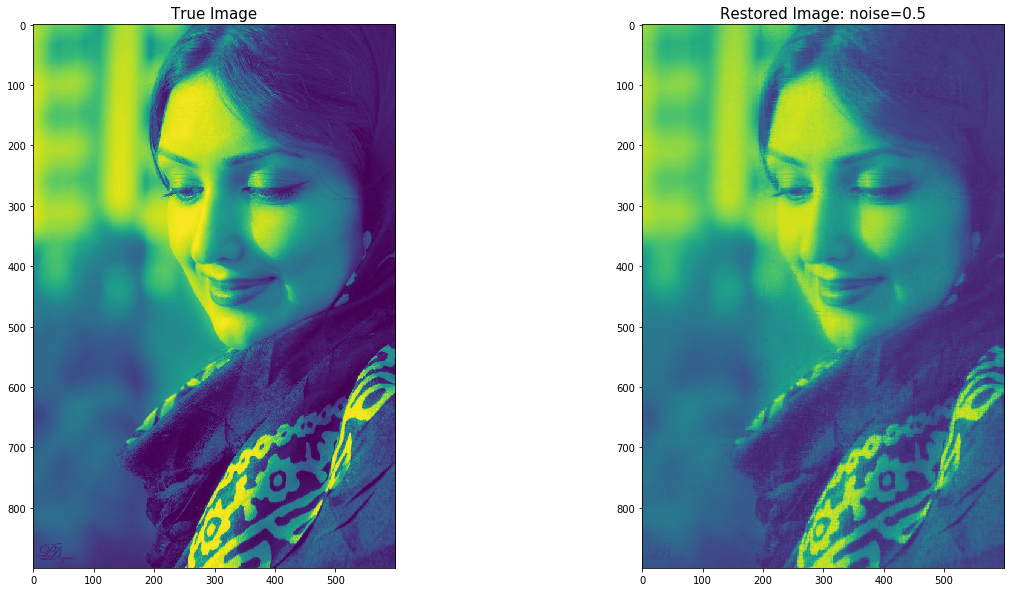

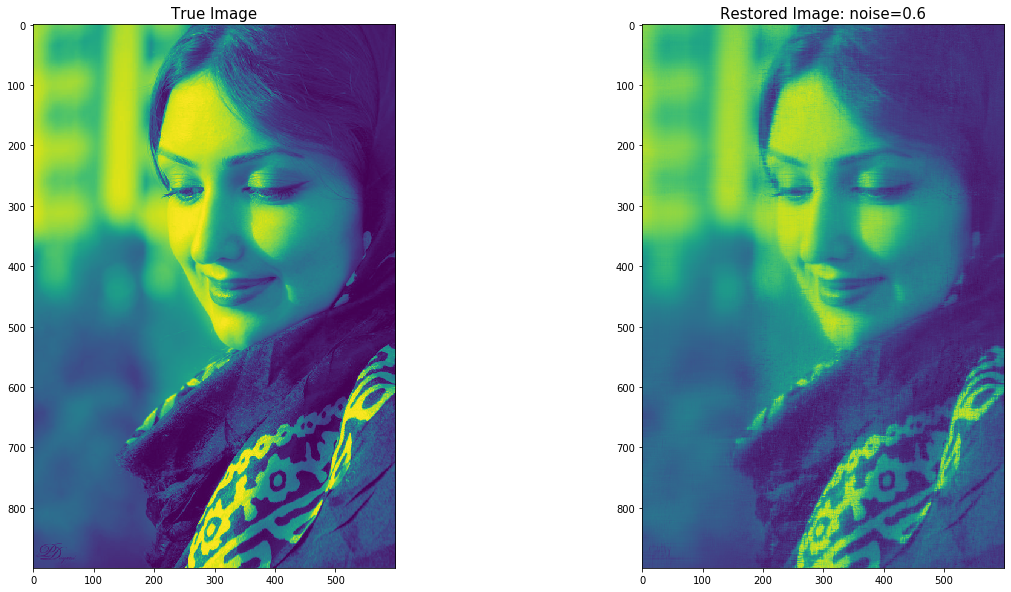

In [13]:
plt.figure(figsize=(20, 10))
for k, n in enumerate(noise):
    mask, img_noise = pepper_salt_noise(n, img)
    img_damaged = np.where(mask == 0, np.nan, img_noise)
    
    R_hat = nuclear_norm_solve(img_damaged, mask)
    
    print("** NUCN")
    print("RMSE:", calc_unobserved_rmse(img, R_hat, mask))
    print("SSIM", ssim(img,R_hat))
    
    img_g = cv2.convertScaleAbs(R_hat, alpha=(255.0))
    cv2.imwrite('outfile_' +str(n)+'.jpg', img_g)
    
    plot_proc(img, R_hat, 'Restored Image: noise='+str(n))